# PMC - Rosenbrock example

Importing libraries and setting the random seed for reproducibility.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pocomc as pc

np.random.seed(0)

/home/david/anaconda3/envs/pocomc/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Defining the likelihood and prior

The Rosenbrock log likelihood is given by
$$
\log \mathcal{L}(x) = -\sum_{i=1}^{N/2}\left[10\left(x_{2i-1}^{2}-x_{2i}\right)^{2}+\left(x_{2i-1}-1\right)^{2} \right]
$$
with $N=20$ dimensions. Our prior is given by $\pi(x) = U(-10, 10)$ for all dimensions.

We use PMC to obtain samples $x_i \sim \mathcal{P}(x) \propto \mathcal{L}(x)\pi(x)$.

In [2]:
n_dim = 20  # Number of dimensions


###############################
### Defining the likelihood ###
###############################

def log_likelihood(x):
    return -np.sum(10.0 * (x[:, ::2] ** 2.0 - x[:, 1::2]) ** 2.0 + (x[:, ::2] - 1.0) ** 2.0, axis=1)


###############################
##### Defining the prior ######
###############################

lower = np.full(n_dim, -10.)  # lower bound of the prior
upper = np.full(n_dim, 10.)  # upper bound of the prior
bounds = np.c_[lower, upper]
const = np.sum(np.log(upper - lower))  # log of the Uniform density


def log_prior(x):
    if np.any((x < lower) | (x > upper)):  # If any dimension is out of bounds, the log prior is -infinity
        return -np.inf
    else:
        return -const

## Running PMC

We run PMC with 1000 walkers, initialized to be prior samples.

In [3]:
n_walkers = 1000
prior_samples = np.random.uniform(size=(n_walkers, n_dim), low=-10.0, high=10.0)

pmc = pc.Sampler(
    n_walkers,
    n_dim,
    log_likelihood,
    log_prior,
    vectorize_likelihood=True,
    bounds=bounds,
    random_state=0
)
pmc.run(prior_samples)

Iter: 5it [00:18,  4.11s/it, beta=1.64e-5, calls=41000, ESS=0.95, logZ=-2.7, accept=0.25, N=10, scale=0.99, corr=0.733]    /home/david/PycharmProjects/pocomc/pocomc/tools.py:76: UserWarning: Weights do not sum to 1 and have been renormalized.
  warnings.warn("Weights do not sum to 1 and have been renormalized.")
Iter: 52it [03:52,  4.78s/it, beta=0.0166, calls=771000, ESS=0.95, logZ=-27.7, accept=0.227, N=29, scale=0.587, corr=0.753]   /home/david/PycharmProjects/pocomc/pocomc/scaler.py:386: RuntimeWarning: invalid value encountered in logaddexp
  p = np.exp(-np.logaddexp(0, -u[:, self.mask_both]))
/home/david/anaconda3/envs/pocomc/lib/python3.10/site-packages/numpy/linalg/linalg.py:2094: RuntimeWarning: invalid value encountered in slogdet
  sign, logdet = _umath_linalg.slogdet(a, signature=signature)
Iter: 91it [06:53,  4.55s/it, beta=1, calls=1459000, ESS=1, logZ=-56.4, accept=0.225, N=10, scale=1.04, corr=0.741]          


## Visualizing the PMC posterior

We visualize the final PMC samples. The samples accurately represent the posterior.

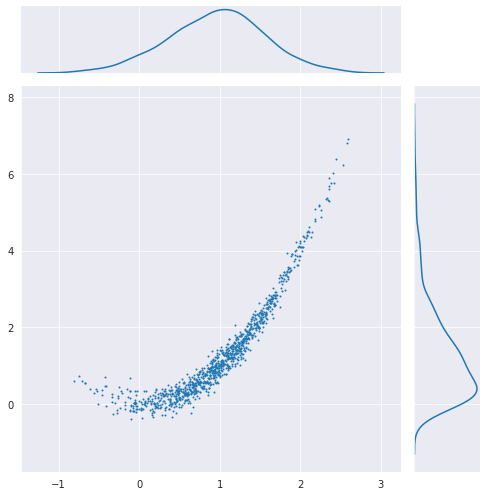

In [4]:
import seaborn as sns

x = pmc.results['samples']
g = sns.JointGrid(height=7)
g.ax_joint.scatter(x[:, 0], x[:, 1], s=1.0)
sns.kdeplot(x=x[:, 0], ax=g.ax_marg_x)
sns.kdeplot(y=x[:, 1], ax=g.ax_marg_y)
plt.show()

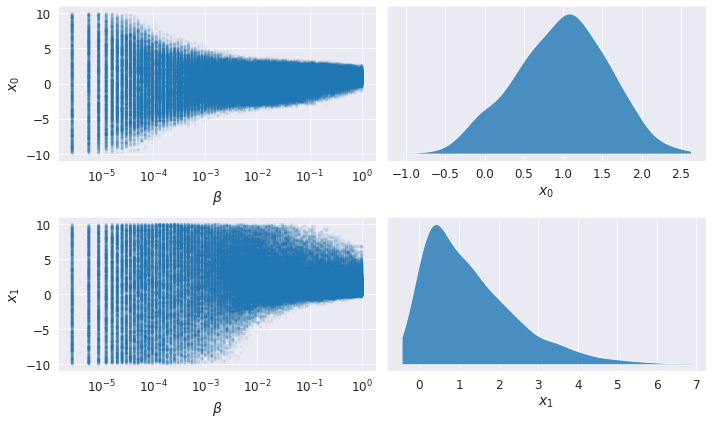

In [5]:
pc.plotting.trace(pmc.results, dims=[0, 1])
plt.show()

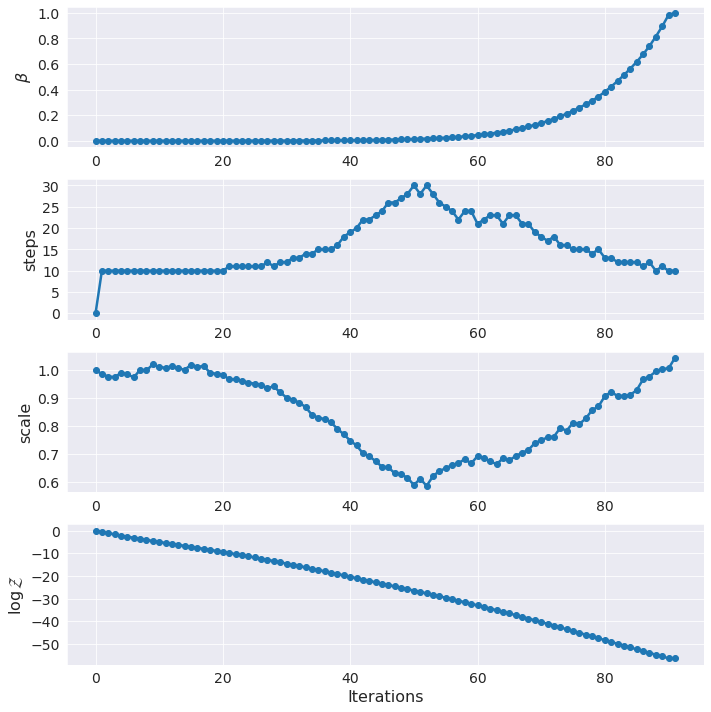

In [6]:
pc.plotting.run(pmc.results)
plt.show()